## 単目的ベイズ最適化の対話型実行・チュートリアル

目的関数や制約関数を自動的に評価できない場合に、対話型（手作業）で単目的最適化問題のベイズ最適化を実行するためのnotebookです。下記のような用途を想定しています。  
* 関数評価に数値流体力学(CFD)や有限要素解析(FEA)などを使用しており、形状変更や計算格子の生成を手動で行う必要がある場合
* 数値シミュレーションが利用できず、関数評価に実験室などでの計測が必要である場合
* プログラミングをせずにベイズ最適化を試してみたい場合

Copyright (c) 2022 Nobuo Namura  
This code is released under the MIT License, see LICENSE.txt.  

### 0. Import
requirement.txt に記載のライブラリ群をインストール（"pip install -r requirements.txt"）してから、下記のセルを実行（Shift + Enter）してください。

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import os
import shutil
from bo import BayesianOptimization
import test_problem

### 1. 設定

#### 最適化問題定義  
下記をそのまま実行するとチュートリアル用のデータを読み込みます。  
ご自身の問題にベイズ最適化を適用する場合は、以下の2つファイルと同様の形式でcsvファイルを作成し、下記セルのファイル名を作成したファイルに合わせてください。  
* design_space_branin.csv: 設計変数の定義域（最小値、最大値）を指定するファイル。  
* sample_branin.csv: ガウス過程モデルの学習データを記載したファイル。行方向に各学習データ、列方向に設計変数（$x1, x2, ...$）、目的関数（$f1$）、制約関数（$g1, g2, ...$）を入力。制約条件がない場合、制約関数は省略可能  

制約関数は、$g(x) <= 0$ の形に式変形した値を入力してください。  
例：ある場所の応力 $\sigma(x)$ が、ある値 $c$ 以下に制約したい場合、$\sigma(x) \leqq c$ を変形して、$\sigma(x) - c \leqq 0$ とし、$g(x) = \sigma(x) - c$ の数値をファイルに入力してください。

In [2]:
# ここを編集 -----------------------------------------------------------------
f_design_space = 'design_space_branin.csv'     # 設計変数の定義域を指定するファイルの名前
f_sample = 'sample_branin.csv'                 # 学習データを記載したファイルの名前
n_add = 3                                      # ベイズ最適化で生成する解候補の数
# ----------------------------------------------------------------------------

# ファイル読み込み
df_design_space = pd.read_csv(f_design_space)
df_sample = pd.read_csv(f_sample)
nf = df_sample.columns.str.contains('f').sum() # 目的関数の数を読み込み
ng = df_sample.columns.str.contains('g').sum() # 制約関数の数を読み込み
nx = df_sample.columns.str.contains('x').sum() # 設計変数の数
ns = len(df_sample)                            # 学習データの数

# 最大化すべき目的関数がある場合や、関数にノイズが含まれる場合は以下を修正 ---
MIN = np.full(nf, True)                        # 各目的関数に対して、「True=最小化, False=最大化」を配列で指定
NOISE = np.full(nf+ng, False)                  # 各目的関数、制約関数に対して、「True=ノイズあり, False=ノイズなし」を配列で指定
# ----------------------------------------------------------------------------

#### パラメータ設定  
下記のパラメータを調整することで、より高度な最適化が可能です。ベイズ最適化や遺伝的アルゴリズム(GA)について詳しくない場合、下記の推奨値をそのまま利用ください。

In [3]:
CRITERIA = 'EI'                                # ベイズ最適化の獲得関数を選択：EI, GP-MI, Error, or Estimation
npop_ea = 100                                  # 獲得関数の最適化に用いるGAの個体数
ngen_ea = 200                                  # 獲得関数の最適化に用いるGAの世代数

### 2. 初期化

In [4]:
gp = BayesianOptimization(df_sample, df_design_space, MIN)

### 3. ガウス過程モデルの学習  
遺伝的アルゴリズム(GA)を用いて、尤度が最大となるようにハイパーパラメータを決定します。
* theta0: ハイパーパラメータの上限値、$10^{theta0}$ が上限値になります
* npop: GAの個体数
* ngen: GAの最大世代数
* mingen: GAの最小世代数
* STOP: Trueの場合、mingen以上の世代数で収束判定を行い、収束した場合にはngenに至る前に最適化を打ち切ります
* PRINT: Trueの場合、GAでの最適化履歴を出力します
* theta: 最適化によって得られたハイパーパラメータ (出力)

In [5]:
warnings.simplefilter('ignore')
theta = gp.training(theta0 = 3.0, npop = 500, ngen = 500, mingen=0, STOP=True, NOISE=NOISE, PRINT=False)
gp.construction(theta)

--- 1-th function estimation -------------------


### 4. 解候補の生成  
遺伝的アルゴリズム(GA)を用いて獲得関数を最大化し、次に目的関数、制約関数を評価すべき解候補を生成します。  
※下記に出力される目的関数（$f1$）と制約関数（$g1, g2, ...$）の値は、ガウス過程モデルによる予測値です。

In [6]:
x_add, f_add_est, g_add_est = gp.optimize_single_objective_problem(CRITERIA=CRITERIA, n_add=n_add, npop_ea=npop_ea, ngen_ea=ngen_ea, PRINT=False, RETRAIN=True, theta0=3.0, npop=100, ngen=100, mingen=0, STOP=True)
add_sample = pd.DataFrame(np.hstack([x_add, f_add_est, g_add_est]), columns=np.hstack(['x'+np.arange(1,1+gp.nx).astype(str).astype(object), 'f'+np.arange(1,1+gp.nf).astype(str).astype(object), 'g'+np.arange(1,1+gp.ng).astype(str).astype(object)]))
add_sample

--- 1-th function estimation -------------------
--- 1-th function estimation -------------------


,x1,x2,f1
0,0.074147,1.000000,14.408519
1,0.969808,0.155386,-0.564772
2,0.575088,0.000000,5.540055


### 5. 可視化 (設計変数が2個の場合のみ)

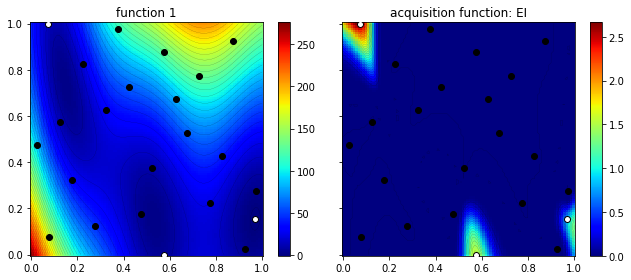

In [7]:
if nx == 2:
    fig, ax = plt.subplots(1, nf+ng+1, figsize=(4.5*(nf+ng+1),4), tight_layout=True, sharex='all', sharey='all')
    x = gp.xmin[0]+np.linspace(0, 1, 101)*(gp.xmax[0]-gp.xmin[0])
    y = gp.xmin[1]+np.linspace(0, 1, 101)*(gp.xmax[1]-gp.xmin[1])
    X, Y = np.meshgrid(x, y)
    F = np.zeros(np.shape(X))
    EI = np.zeros(np.shape(X))
    for k in range(nf+ng):
        for i in range(len(X[:,0])):
            for j in range(len(X[0,:])):
                F[i,j], S = gp.estimation(np.array([X[i,j],Y[i,j]]), nfg=k)
                if k==0:
                    if CRITERIA=='EI' or CRITERIA=='Error':
                        EI[i,j] = -1*gp.acquisition_function(np.array([X[i,j],Y[i,j]]))
                    elif CRITERIA=='GP-MI' or CRITERIA=='Estimation':
                        EI[i,j] = np.where(MIN, 1, -1)*gp.acquisition_function(np.array([X[i,j],Y[i,j]]))
        ax[k].set_title('function '+str(k+1))
        ax[k].scatter(gp.x[:,0], gp.x[:,1], c='black', zorder=3)
        ax[k].scatter(x_add[:,0], x_add[:,1], c='white', edgecolor='black', zorder=4)
        pcm = ax[k].pcolor(X, Y, F, cmap='jet', shading='auto', zorder=1)
        fig.colorbar(pcm, ax=ax[k])
        ax[k].contour(X, Y, F, 40, colors='black', linestyles='solid', linewidths=0.1, zorder=2)

        if k==0:
            ax[-1].set_title('acquisition function: ' + CRITERIA)
            ax[-1].scatter(gp.x[:,0], gp.x[:,1], c='black', zorder=3)
            ax[-1].scatter(x_add[:,0], x_add[:,1], c='white', edgecolor='black', zorder=4)
            pcm = ax[-1].pcolor(X, Y, EI, cmap='jet', shading='auto', vmin=0, zorder=1)
            fig.colorbar(pcm, ax=ax[-1])
            ax[-1].contour(X, Y, EI, 40, colors='black', linestyles='solid', linewidths=0.1, zorder=2)

### 6. ファイル書き出し
* 生成されたファイルの設計変数に対する目的関数、制約関数の値を、実際に評価・入力してファイルを上書き保存してください
* "1. 設定" に戻り、"f_sample"のファイル名を上書き保存したファイル名に変更して、これまでの操作を繰り返します（納得できる解が得られたらベイズ最適化を終了します）

In [8]:
path, extension = os.path.splitext(f_sample)
f_sample_out =  path + '_' + str(gp.ns+n_add) + extension
shutil.copyfile(f_sample, f_sample_out)
with open(f_sample_out, 'a') as file:
    np.savetxt(file, x_add, delimiter=',')

### おまけ: チュートリアル用データ"sample_branin.csv"の目的関数評価
* f_sampleにsample_branin.csvを用いている場合、以下を実行すると解候補の目的関数の値を評価し、ファイルに出力します
* **main.py**を使うと、この操作を自動的に実行できます。 

In [9]:
f_add = np.array([test_problem.Branin(x_add[i,:]) for i in range(n_add)])
path, extension = os.path.splitext(f_sample)
f_sample_sgm =  path + '_' + str(gp.ns+n_add) + '_evaluated' + extension
shutil.copyfile(f_sample, f_sample_sgm)
with open(f_sample_sgm, 'a') as file:
    np.savetxt(file, np.hstack([x_add, f_add]), delimiter=',')